\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = pd.read_csv('marketing.csv')
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan']) #, drop_first=True)
y = np.where(X.pop('y')=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_train.sum()/len(y_train)

0.11782377603908752

## (b) {-}

In [2]:
from sklearn.linear_model import LogisticRegression
import pickle

clf = LogisticRegression(penalty='none').fit(X_train, y_train)

with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)
    
y_pred = clf.predict(X_test)
1 - accuracy_score(y_test, y_pred)

0.11548257372654158

## (c) {-}

In [4]:
y_pred = np.zeros_like(y_test)
1 - accuracy_score(y_test, y_pred)

0.11528150134048254

## (d) {-}

In [5]:
predict_proba_test = clf.predict_proba(X_test)[:, 1]
bestIdxSet = predict_proba_test.argsort()[-1000:]

y_select = y_test[bestIdxSet]
y_test.sum()/len(y_test), y_select.sum()/len(y_select)

(0.11528150134048257, 0.291)

## (e) {-}

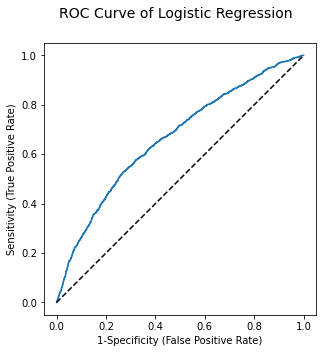

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import roc_curve
from pandas import DataFrame

fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 

def plot_roc(spec, sens):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    fig.suptitle('ROC Curve of Logistic Regression', fontsize=14)
    ax.plot(1-spec, sens)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')
    return ax
    
plot_roc(1-fpr, tpr)
plt.show()

# 2. {-}

## (a) {-}

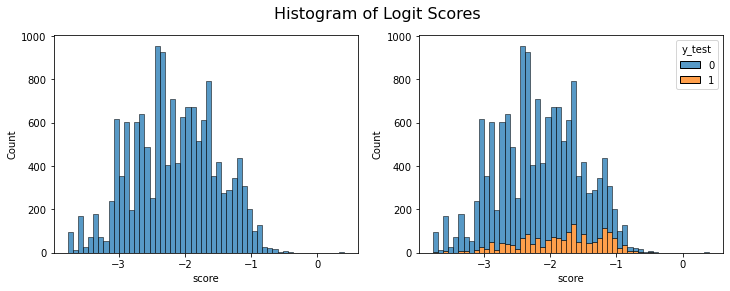

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

pn, pp = clf.predict_proba(X_test).T
scores = np.log(pp/pn)

df = DataFrame({'score': scores, 'y_test': y_test})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(scores, ax=ax[0])
sns.histplot(x='score', hue='y_test', data=df, multiple='stack', ax=ax[1])
ax[0].set(xlabel='score')
plt.suptitle('Histogram of Logit Scores', fontsize=16)
plt.show()

## (b) {-}

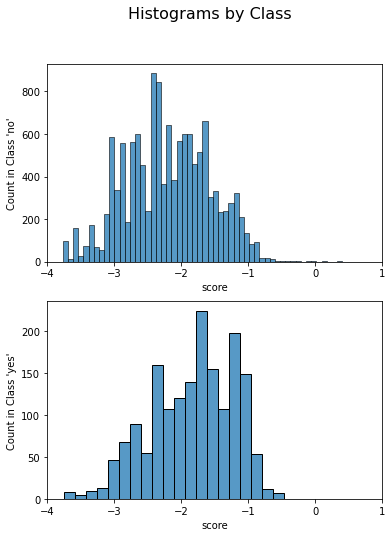

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(x='score', data=df[df['y_test']==0], ax=ax[0])
sns.histplot(x='score', data=df[df['y_test']==1], ax=ax[1])
ax[0].set(xlim=(-4, 1), ylabel="Count in Class 'no'")
ax[1].set(xlim=(-4, 1), ylabel="Count in Class 'yes'")
plt.suptitle('Histograms by Class', fontsize=16)
plt.show()

## (c) {-}

\begin{align*}
TPR &= P(\text{score} > T ~|~ \text{class 'yes'}) = \int_T^\infty f_1(x)\,dx\\
FPR &= 1 - \text{specificity} \\
    &= 1 - P(\text{score} < T ~|~ \text{class 'no'}) \\
    &= 1 - P(\text{score} > T ~|~ \text{class 'no'}) \\
    &= \int_T^\infty f_0(x)\,dx\\
\end{align*}

$TPR$ corresponds to the blue area on the right of the vertical line on the class 'yes' histogram, while
$FPR$ corresponds to the blue area on the right of the vertical line on the class 'no' histogram. 

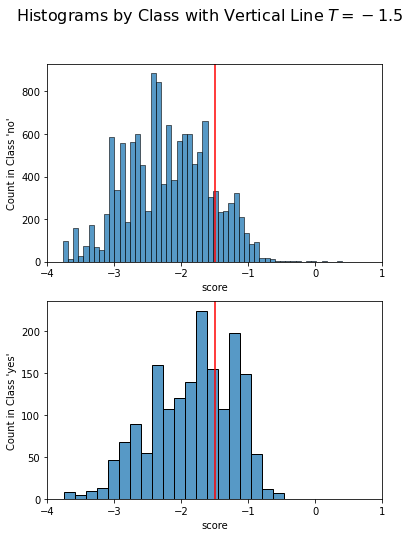

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(x='score', data=df[df['y_test']==0], ax=ax[0])
sns.histplot(x='score', data=df[df['y_test']==1], ax=ax[1])
ax[0].set(xlim=(-4, 1), ylabel="Count in Class 'no'")
ax[1].set(xlim=(-4, 1), ylabel="Count in Class 'yes'")
ax[0].axvline(x=-1.5, color='r')
ax[1].axvline(x=-1.5, color='r')
plt.suptitle('Histograms by Class with Vertical Line $T=-1.5$', fontsize=16)
plt.show()

## (d) {-}

Plug in $f(t) = FPR(t)$, $g(t) = TPR(t)$, $t_0=\infty$, $t_f = -\infty$ to get
\begin{align*}
AUC &= \int_{t_0}^{t_f} g(t) f^\prime(t)\,dt  \\
    &= \int_{\infty}^{-\infty} TPR(t) FPR^\prime(t)\,dt.
\end{align*}

## (e) {-}

Note that
\begin{align*}
FPR^\prime(T) = \frac{d}{dT}\int^\infty_Tf_0(x)\,dx = -f_0(T).
\end{align*}
Plug this into the above $AUC$ integral to get 
\begin{align*}
AUC &= \int_{\infty}^{-\infty} \left(\int_T^\infty f_1(x)\,dx\right) (-f_0(T))\,dT \\
&= \int_{-\infty}^{\infty} \int_T^\infty f_0(T)f_1(x)\,dx\,dT.
\end{align*}
Assuming that $S_1$ and $S_2$ are independent, $f_0(T)f_1(x)$ is simply their joint distribution, so this integral is the probability of $(S_1, S_2)$ being in the region $\{(x, T)\in \mathbb R^2 ~|~ -\infty < T < \infty, T < x < \infty\} = \{(x, T)\in \mathbb R^2 ~|~ T < x\}$, which is equivalent to the $\mathbb P(S_1 > S_0)$. Thus we conclude 
\begin{align*}
AUC = \mathbb P(S_1 > S_0). 
\end{align*}
Below is a plot of the domain of integration. 

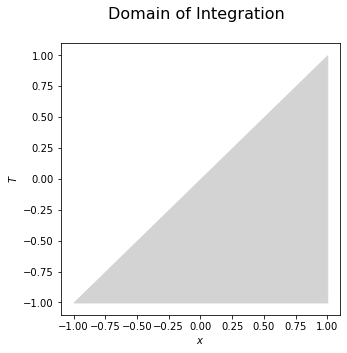

In [3]:
import matplotlib.pyplot as plt
from pandas import DataFrame

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x = [-1, 1]
y = [-1, 1]
ax.fill_between(x, -1, y, color='lightgray')
ax.set(xlabel='$x$', ylabel='$T$')
plt.suptitle('Domain of Integration', fontsize=16)
plt.show()

# 3. {-}

## (a) {-}

```scores``` defined in 2(a)

In [10]:
import numpy as np

threshold = -1

def eval_estimate(estimate, truth, loss_FP=5, loss_FN=100):
    tp = (truth & estimate).sum()
    fp = ((~truth) & estimate).sum()
    fn = (truth & (~estimate)).sum()
    tn = ((~truth) & (~estimate)).sum()

    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    loss = fp*loss_FP + fn*loss_FN
    
    return (sens, spec, loss)

eval_estimate(scores > threshold, y_test)

(0.053488372093023255, 0.9808333333333333, 164065)

## (b) {-}

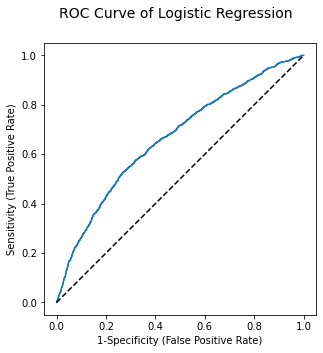

In [11]:
unique_logits = np.sort(np.unique(scores))
midpts = (unique_logits[1:] + unique_logits[:-1])/2
sens, spec, loss = np.vectorize(lambda threshold: eval_estimate(scores > threshold, np.array(y_test, dtype=bool)))(midpts)

plot_roc(spec, sens)

## (c) {-}

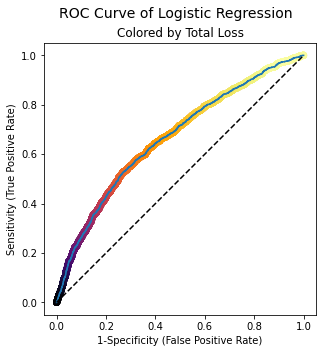

In [41]:
ax = plot_roc(spec, sens)
ax.scatter(1-spec, sens, c=-loss, cmap=cm.inferno)
ax.set(title='Colored by Total Loss')
plt.show()

## (d) {-}

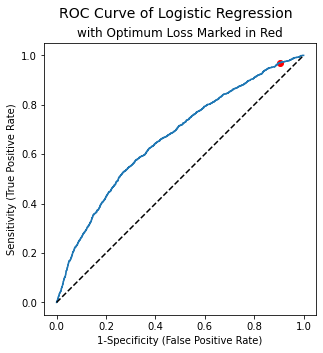

In [49]:
optimumIdx = np.argmin(loss)

ax = plot_roc(spec, sens)
ax.scatter([1-spec[optimumIdx]], [sens[optimumIdx]], color='red')
ax.set(title='with Optimum Loss Marked in Red')
plt.show()